In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
def load_data(directory, filename):
    '''
    Load data from a CSV file.
    
    '''
    return pd.read_csv(directory + filename)


def explore_data(data, column):
    '''
    Explore the data and visualize various aspects.
    '''
    # Display summary statistics
    print("Summary Statistics:")
    print(data.describe())
    print(data.info())
    print('Correlation : ', data.corr())
    
    # Plot the data
    plt.figure()
    plt.plot(data.index, data[column])  # Use index for x-axis
    plt.title('Hospital visit per day')
    plt.xlabel('Date')
    plt.ylabel('Visit count')
    plt.tight_layout()
    plt.show()
    
    # Boxplot of the data
    plt.figure()
    sns.boxplot(x=data[column])
    plt.title('Hospital visit per day')
    plt.tight_layout()
    plt.show()
    
    # Plot data distribution
    plt.figure()
    sns.histplot(data[column], kde=True)
    plt.title('Distribution of hospital visit per day')
    plt.xlabel('Hospital visit per day')
    plt.tight_layout()
    plt.show()


def data_cleaning(data, new_column, covis_date):
    '''
    Perform data cleaning and preparation.
    '''
    data = data.drop_duplicates(subset=['Date'])
    data = data.dropna()
    data = data.rename(columns={'Counts': new_column})
    data = data.reset_index(drop=True)
    
    # Add additional column to indicate before/after COVID (as covariate)
    data.loc[:, 'COVID_presence'] = (data['Date'] >= covis_date).astype(int)

    # Use date as index and remove the date column
    data.index = pd.to_datetime(data['Date'], format='%Y-%m-%d')
    data['Date'] = pd.to_datetime(data['Date'])
    del data['Date']
    
    return data


def seasonal_dec(data):
    '''
    Plot trend, seasonality, and remainder (residuals or noise).
    '''
    decompose_data = seasonal_decompose(data['VisitCounts'], model="additive")
    
    plt.figure()
    decompose_data.observed.plot(label='Observed')
    decompose_data.trend.plot(label='Trend')
    decompose_data.seasonal.plot(label='Seasonal')
    decompose_data.resid.plot(label='Residual')
    plt.legend()
    plt.show()


def stationary_test(data):
    '''
    Perform ADFuller test for stationarity.
    '''
    dftest = adfuller(data['VisitCounts'], autolag='AIC')
    print("P-Value : ", dftest[1])
    print("Num Of Lags : ", dftest[2])


def build_model(train, test):
    '''
    Build and fit the SARIMAX model, and make predictions.
    '''    
    exog_train = train['COVID_presence'].astype(int)
    exog_test = test['COVID_presence'].astype(int)
    
    # Build and fit the SARIMAX model with exogenous variable
    model = SARIMAX(train['VisitCounts'], exog=exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    model = model.fit(method='powell', disp=False)  # Set disp=False to suppress convergence warnings
    
    # Make predictions using exogenous variable for testing
    prediction = model.get_forecast(steps=len(exog_test), exog=exog_test)
    
    return prediction


def fit_validate_model(data, date1, date2):
    '''
    Split the data into training and testing sets, build and fit the model,
    validate the model, and plot the results.
    '''
    train = data[data.index < pd.to_datetime(date1, format='%Y-%m-%d')]
    test = data[data.index > pd.to_datetime(date2, format='%Y-%m-%d')]
    
    # Build and fit the model - Seasonal ARIMA (SARIMA) - and get prediction
    prediction = build_model(train, test)
    prediction = prediction.predicted_mean.values
    prediction = pd.Series(prediction, index=test.index)

    # Model validation
    rmse = np.sqrt(mean_squared_error(test["VisitCounts"].values, prediction))
    mae = mean_absolute_error(test["VisitCounts"].values, prediction)
    r2 = r2_score(test["VisitCounts"].values, prediction)
    
    # Percent error calculation function
    def calculate_percent_error(metric, mean_value):
        return 100 * (metric / mean_value)
    
    # Print metrics in a neat format
    print(f"RMSE: {rmse:.2f}")
    print(f'Percent Error using RMSE: {calculate_percent_error(rmse, test["VisitCounts"].mean()):.2f}%')
    print(f"MAE: {mae:.2f}")
    print(f'Percent Error using MAE: {calculate_percent_error(mae, test["VisitCounts"].mean()):.2f}%')
    print(f'R2: {r2:.2f}')
    
    # Plot the data and the prediction
    plt.figure()
    plt.plot(train['VisitCounts'], color="black", label='Training Data')
    plt.plot(test['VisitCounts'], color="red", label='Test Data')
    plt.plot(prediction, color='blue', label='Predictions')
    plt.ylabel('Hospital visit per day')
    plt.xlabel('Date')
    plt.xticks(rotation=50)
    plt.legend()
    return prediction

Summary Statistics:
Index(['Date', 'Counts'], dtype='object')
         Date  Counts
0  2019-12-31  257599
1  2020-01-01  232750
2  2020-01-02  278720
3  2020-01-03  239850
4  2020-01-04   25200
              Counts
count     183.000000
mean   219867.819672
std    145048.570962
min      7600.000000
25%     34860.000000
50%    264670.000000
75%    325480.000000
max    478670.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    183 non-null    object
 1   Counts  183 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB
None
Correlation :          Counts
Counts     1.0


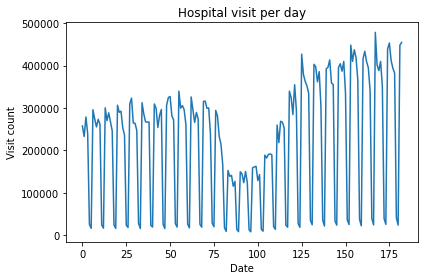

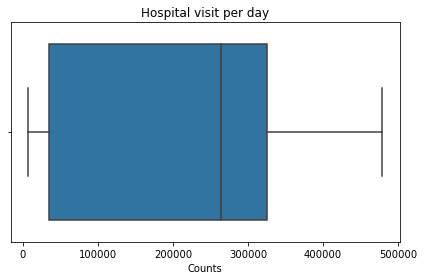

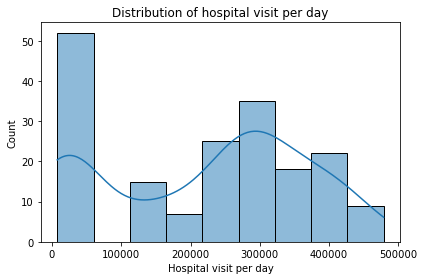

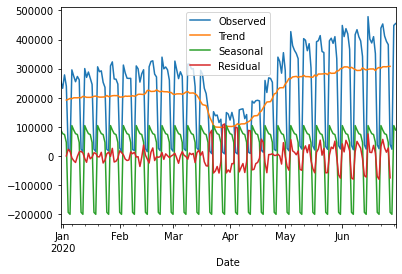

P-Value :  0.32835792095691896
Num Of Lags :  14


C:\Users\srabb\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\srabb\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


RMSE: 26060.38
Percent Error using RMSE: 8.37%
MAE: 19377.16
Percent Error using MAE: 6.22%
R2: 0.98


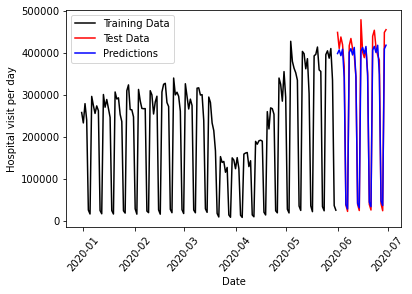

In [3]:

if __name__ == '__main__':
    # Set the directory of the data
    directory = 'C:/Users/Data/'
    
    # Import visit data
    visit_data = load_data(directory, 'visit_data.csv')
    
    # Explore the data
    explore_data(visit_data, 'Counts')
    
    # Clean and prepare the data
    visit_data = data_cleaning(visit_data, 'VisitCounts', '2020-03-19')
    
    # Plot seasonal decomposition
    seasonal_dec(visit_data)
    
    # Perform ADFuller test
    stationary_test(visit_data)
    
    # Build, fit, validate, and plot the model
    prediction = fit_validate_model(visit_data, "2020-06-01", "2020-05-31")